In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Reading Data from the folder
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Final_AQI.csv")
#Date Formatting
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data=data[data['Date'].dt.year>=2018]

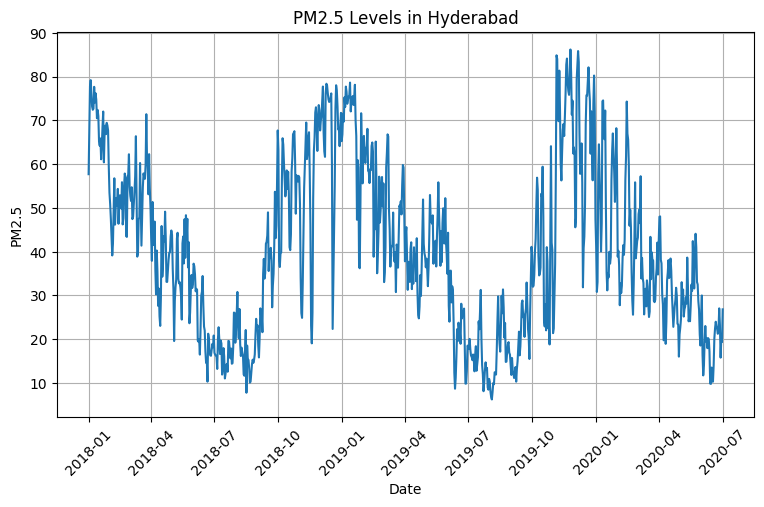

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for Hyderabad and PM2.5 values
Hyderabad_data = data[data['City'] == 'Hyderabad']
pm25_values = Hyderabad_data['PM2_5']
dates = pd.to_datetime(Hyderabad_data['Date'])

# Create the plot
plt.figure(figsize=(9, 5))
plt.plot(dates, pm25_values)
plt.title('PM2.5 Levels in Hyderabad')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

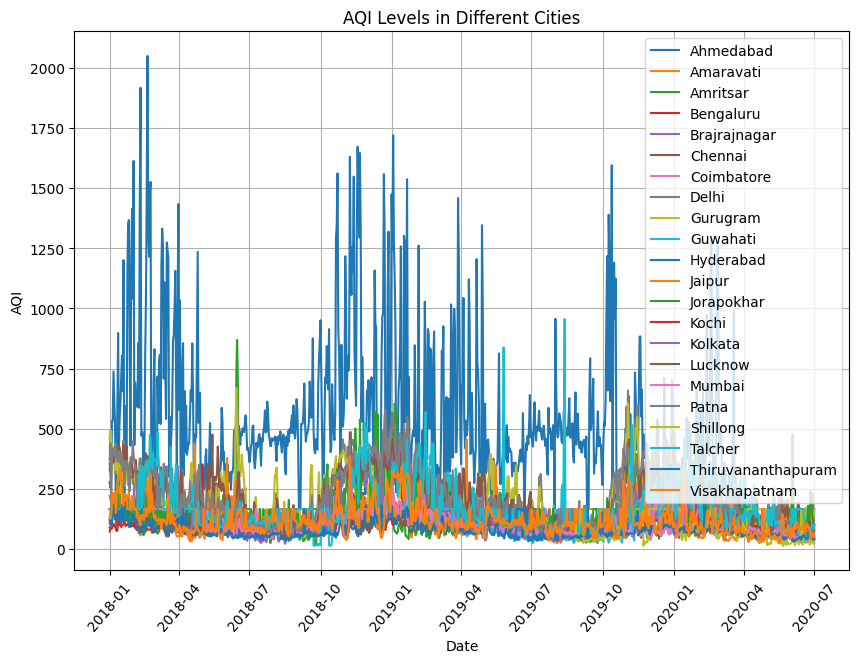

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by city
grouped_data = data.groupby('City')

# Create the plot
plt.figure(figsize=(10, 7))

# Plot PM2.5 values for each city
for city, city_data in grouped_data:
    pm25_values = city_data['AQI']
    dates = pd.to_datetime(city_data['Date'])
    plt.plot(dates, pm25_values, label = city)

plt.title('AQI Levels in Different Cities')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.xticks(rotation=50)
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

**Create the SARIMA Model** 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
city = 'Hyderabad'
variable = 'AQI'

# Filter the data for the specified city and variable
city_data = data[data['City'] == city][variable]
city_data = city_data.reset_index()
city_data = city_data.drop(columns=['index'])
print(city_data)

       AQI
0    122.0
1    126.0
2    163.0
3    174.0
4    164.0
..     ...
908   58.0
909   49.0
910   47.0
911   46.0
912   48.0

[913 rows x 1 columns]


In [ ]:
print(type(city_data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
train_data = city_data[:-180]  # Use all data except the last 180 days for training -700 to -180
test_data = city_data[-180:]  # Use the last 180 days for testing  -180 to 0

In [ ]:
# Define the SARIMA model with appropriate parameters (p, d, q, P, D, Q, s)
order = (1, 0, 3)  # (p, d, q)
seasonal_order = (1, 0, 1, 8)  # (P, D, Q, s)

# Create and fit the SARIMA model
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

In [ ]:
# Forecast the values for the test data period
predictions = model_fit.forecast(len(test_data))

In [ ]:
# Calculate the mean squared error
rmse = mean_squared_error(test_data, predictions, squared=False)

# Print the MSE
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the MAPE
mape=mean_absolute_percentage_error(test_data, predictions)
print('Mean Absolute percentage error (MAPE):', mape)

Root Mean Squared Error (RMSE): 22.38283437753301
Mean Absolute percentage error (MAPE): 0.1938242302652965


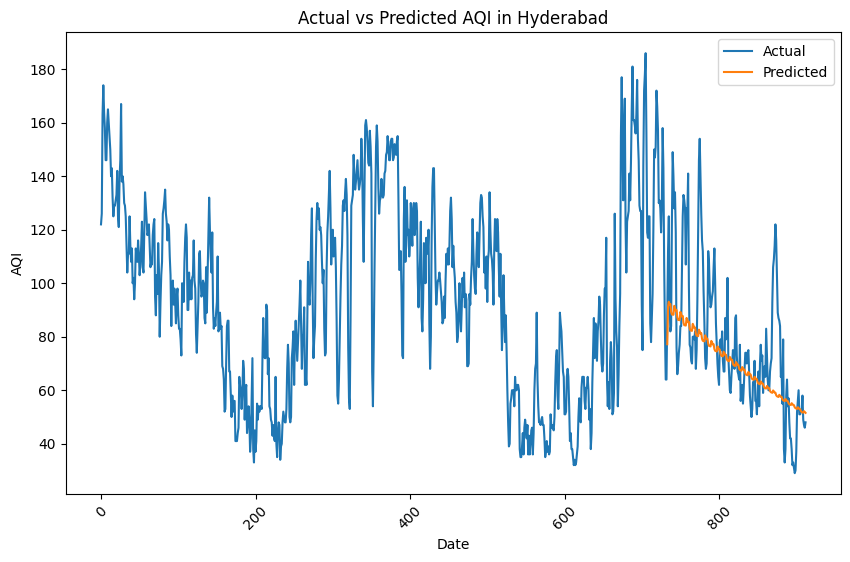

In [ ]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(city_data.index, city_data, label='Actual')
plt.plot(predictions.index, predictions, label='Predicted')
plt.title(f'Actual vs Predicted {variable} in {city}')
plt.xlabel('Date')
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.legend()
plt.show()


**LSTM Model**

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# Load the AQI data from the CSV file\
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_AQI.csv')
city = 'Hyderabad'
variable = 'AQI'

# Filter the data for the specified city and variable
city_data = data[data['City'] == city][variable]
city_data = city_data.reset_index()
city_data = city_data.drop(columns=['index'])
print(city_data)
aqi_data=city_data

             AQI
0     166.463582
1     166.463582
2     166.463582
3     166.463582
4     166.463582
...          ...
2001   58.000000
2002   49.000000
2003   47.000000
2004   46.000000
2005   48.000000

[2006 rows x 1 columns]


In [ ]:
# Normalize the AQI data
scaler = MinMaxScaler(feature_range=(0, 1))
aqi_normalized = scaler.fit_transform(aqi_data.values.reshape(-1, 1))

# Prepare the data for LSTM
def prepare_data(aqi_data, n_steps):
    X, y = [], []
    for i in range(len(aqi_data)-n_steps):
        X.append(aqi_data[i:i+n_steps])
        y.append(aqi_data[i+n_steps])
    X = np.array(X)
    y = np.array(y)
    return X, y

# Define the number of time steps for the LSTM model
n_steps = 10

# Prepare the data
X, y = prepare_data(aqi_normalized, n_steps)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape the input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(n_steps, 1)))
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=17, batch_size=27)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Make predictions with the model
predicted_values = model.predict(X_test)

# Denormalize the predicted and actual values
predicted_values_denormalized = scaler.inverse_transform(predicted_values)
y_test_denormalized = scaler.inverse_transform(y_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_denormalized, predicted_values_denormalized))
print(f"RMSE: {rmse}")

# Calculate the MAPE
mape=mean_absolute_percentage_error(y_test_denormalized, predicted_values_denormalized)
print('Mean Absolute percentage error (MAPE):', mape)

# Print some example predictions
for i in range(10):
    print(f"Actual: {y_test_denormalized[i]}, Predicted: {predicted_values_denormalized[i]}")

Epoch 1/17
60/60 [==============================] - 4s 13ms/step - loss: 0.0066
Epoch 2/17
60/60 [==============================] - 1s 20ms/step - loss: 0.0043
Epoch 3/17
60/60 [==============================] - 1s 15ms/step - loss: 0.0041
Epoch 4/17
60/60 [==============================] - 1s 13ms/step - loss: 0.0040
Epoch 5/17
60/60 [==============================] - 1s 16ms/step - loss: 0.0040
Epoch 6/17
60/60 [==============================] - 1s 21ms/step - loss: 0.0039
Epoch 7/17
60/60 [==============================] - 1s 21ms/step - loss: 0.0038
Epoch 8/17
60/60 [==============================] - 1s 21ms/step - loss: 0.0039
Epoch 9/17
60/60 [==============================] - 1s 15ms/step - loss: 0.0038
Epoch 10/17
60/60 [==============================] - 1s 13ms/step - loss: 0.0037
Epoch 11/17
60/60 [==============================] - 1s 13ms/step - loss: 0.0037
Epoch 12/17
60/60 [==============================] - 1s 12ms/step - loss: 0.0037
Epoch 13/17
60/60 [==================

# Heatwave LSTM

In [10]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# Load the AQI data from the CSV file\
data = pd.read_csv('/content/Final_Heat_Wave.csv')

import pandas as pd
# Assuming you have the data in a DataFrame called "df"
selected_rows = data[(data['district'] == 'Adilabad') & (data['mandal'] == 'Adilabad Urban')]

df=selected_rows[['temp_max']]


# Filter the data for the specified city and variable
df = df.reset_index()
df  = df.drop(columns=['index'])
print(df)
aqi_data=df 

      temp_max
0         26.4
1         28.9
2         31.6
3         31.2
4         31.2
...        ...
1232      32.4
1233      33.0
1234      33.0
1235      32.5
1236      32.9

[1237 rows x 1 columns]


In [13]:
# Normalize the AQI data
scaler = MinMaxScaler(feature_range=(0, 1))
aqi_normalized = scaler.fit_transform(aqi_data.values.reshape(-1, 1))

# Prepare the data for LSTM
def prepare_data(aqi_data, n_steps):
    X, y = [], []
    for i in range(len(aqi_data)-n_steps):
        X.append(aqi_data[i:i+n_steps])
        y.append(aqi_data[i+n_steps])
    X = np.array(X)
    y = np.array(y)
    return X, y

# Define the number of time steps for the LSTM model
n_steps = 10

# Prepare the data
X, y = prepare_data(aqi_normalized, n_steps)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape the input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(n_steps, 1)))
model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(n_steps, 1)))
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Make predictions with the model
predicted_values = model.predict(X_test)

# Denormalize the predicted and actual values
predicted_values_denormalized = scaler.inverse_transform(predicted_values)
y_test_denormalized = scaler.inverse_transform(y_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_denormalized, predicted_values_denormalized))
print(f"RMSE: {rmse}")

# Calculate the MAPE
mape=mean_absolute_percentage_error(y_test_denormalized, predicted_values_denormalized)
print('Mean Absolute percentage error (MAPE):', mape)

# Print some example predictions
for i in range(10):
    print(f"Actual: {y_test_denormalized[i]}, Predicted: {predicted_values_denormalized[i]}")

Epoch 1/10
31/31 [==============================] - 8s 19ms/step - loss: 0.1920
Epoch 2/10
31/31 [==============================] - 1s 19ms/step - loss: 0.0169
Epoch 3/10
31/31 [==============================] - 1s 19ms/step - loss: 0.0130
Epoch 4/10
31/31 [==============================] - 1s 20ms/step - loss: 0.0120
Epoch 5/10
31/31 [==============================] - 1s 20ms/step - loss: 0.0116
Epoch 6/10
31/31 [==============================] - 1s 20ms/step - loss: 0.0115
Epoch 7/10
31/31 [==============================] - 1s 19ms/step - loss: 0.0128
Epoch 8/10
31/31 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 9/10
31/31 [==============================] - 1s 21ms/step - loss: 0.0117
Epoch 10/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0083
Test loss: 0.008345468901097775
8/8 [==============================] - 0s 5ms/step
RMSE: 2.3203800159371046
Mean Absolute percentage error (MAPE): 0.05114762698201728
Actual: [37.3], Predicted: [37.6262

## Heatwave SARIMA

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Load the AQI data from the CSV file\
data = pd.read_csv('/content/Final_Heat_Wave.csv')
import pandas as pd
# Assuming you have the data in a DataFrame called "df"
selected_rows = data[(data['district'] == 'Adilabad') & (data['mandal'] == 'Adilabad Urban')]
df=selected_rows[['temp_max']]
# Filter the data for the specified city and variable
df = df.reset_index()
df  = df.drop(columns=['index'])
print(df)
heat_data=df 

      temp_max
0        26.95
1        28.95
2        31.45
3        30.95
4        30.95
...        ...
1230     32.50
1231     34.60
1232     34.60
1233     32.40
1234     34.60

[1235 rows x 1 columns]


In [9]:
train_data = heat_data[:-180]  # Use all data except the last 180 days for training -700 to -180
test_data = heat_data[-180:]  # Use the last 180 days for testing  -180 to 0

In [14]:
# Define the SARIMA model with appropriate parameters (p, d, q, P, D, Q, s)
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (0, 0, 0, 0)  # (P, D, Q, s)

# Create and fit the SARIMA model
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

In [15]:
# Forecast the values for the test data period
predictions = model_fit.forecast(len(test_data))

In [16]:
# Calculate the mean squared error
rmse = mean_squared_error(test_data, predictions, squared=False)

# Print the MSE
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the MAPE
mape=mean_absolute_percentage_error(test_data, predictions)
print('Mean Absolute percentage error (MAPE):', mape)

Root Mean Squared Error (RMSE): 8.67885712815301
Mean Absolute percentage error (MAPE): 0.2333802582460041


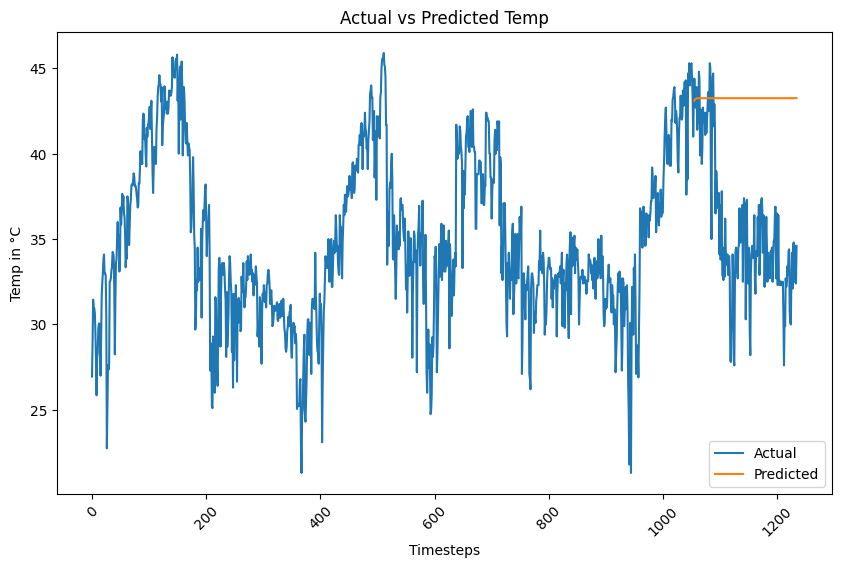

In [27]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(heat_data.index, heat_data, label='Actual')
plt.plot(predictions.index, predictions, label='Predicted')
plt.title(f'Actual vs Predicted Temp')
plt.xlabel('Timesteps')
plt.ylabel("Temp in °C")
plt.xticks(rotation=45)
plt.legend()
plt.show()
